In [1]:
import os
import librosa
import pandas as pd
import numpy as np
import json
import torch
import torchaudio
import torch.nn as nn
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from IPython.display import Audio
from transformers import Wav2Vec2Processor, Wav2Vec2Model, Wav2Vec2ForSequenceClassification
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import random

from sklearn.manifold import TSNE
import umap.umap_ as umap
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import colormaps

from functions import AudioMNISTDataset, create_dataloaders, collate_fn

from scipy.spatial.distance import pdist, squareform

from scipy.spatial.distance import cdist

import time

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [165]:
def plot_tsne(features, labels, n_components=2, perplexity=30, learning_rate=200, max_iter=1000, random_state=42, title="t-SNE Projection of Features"):
    # Ensure 'features' and 'labels' are numpy arrays
    assert isinstance(features, np.ndarray), "Features must be a numpy array"
    assert isinstance(labels, np.ndarray), "Labels must be a numpy array"

    # t-SNE Projection
    tsne = TSNE(n_components=n_components, perplexity=perplexity, learning_rate=learning_rate, max_iter=max_iter, random_state=random_state)
    tsne_embeddings = tsne.fit_transform(features)

    # Set colormap based on number of unique labels
    if len(np.unique(labels)) == 2:
        cmap_rg = ListedColormap(["red", "green"])
        cmap = cmap_rg
    else:
        cmap = 'tab10'
    
    # Plot t-SNE
    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=labels, cmap=cmap, s=5)
    plt.colorbar(scatter)
    plt.title(title)
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.show()
    
def plot_umap(features, labels, n_neighbors=15, min_dist=0.1, n_components=2, random_state=42, title="UMAP Projection of Features"):
    # Ensure 'features' is a numpy array
    assert isinstance(features, np.ndarray), "Features must be a numpy array"
    assert isinstance(labels, np.ndarray), "Labels must be a numpy array"

    # UMAP Projection
    umap_reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components, random_state=random_state)
    umap_embeddings = umap_reducer.fit_transform(features)

    if len(np.unique(labels)) == 2:
        cmap_rg = ListedColormap(["red", "green"])
        cmap = cmap_rg
    else:
        cmap = 'tab10'
    
    # Plot UMAP
    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=labels, cmap=cmap, s=5)
    plt.colorbar(scatter)
    plt.title(title)
    plt.xlabel("UMAP Dimension 1")
    plt.ylabel("UMAP Dimension 2")
    plt.show()

def forward_pass(model, dataloader, metadata):
    """
    Perform a forward pass and collect metadata along with labels.
    
    Args:
        model: The model to run the forward pass on.
        dataloader: A PyTorch DataLoader for the dataset.
        metadata: Metadata dictionary loaded from audioMNIST_meta.json.
    
    Returns:
        result: A list of dictionaries, each containing label, file path, and metadata.
    """
    result = []
    with torch.no_grad():
        for batch in dataloader:
            input_values, labels, file_paths = batch  # File paths are now returned by the DataLoader
            input_values = input_values.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(input_values)

            # Process metadata for each file
            for label, file_path in zip(labels.cpu().numpy(), file_paths):
                # Extract speaker ID from the file path
                speaker_id = os.path.basename(os.path.dirname(file_path))
                speaker_metadata = metadata.get(speaker_id, {})
                
                # Append metadata, label, and file info
                result.append({
                    "label": int(label),
                    "file_path": file_path,
                    "metadata": speaker_metadata,
                    "speaker_id": speaker_id
                })
    return result

def hook(module, input, output):
    # Apply mean pooling over the sequence length dimension (dim=1)
    pooled_output = output[1].mean(dim=1)  # Shape: [batch_size, 768]
    projector_features.append(pooled_output.detach())
    
def register_hook(layer):
    """
    Registers a forward hook to store features in the dynamically provided storage.

    Args:
        layer (nn.Module): The layer to which the hook should be attached.
        feature_storage (list): A mutable list to store the features extracted by the hook.
    
    Returns:
        hook_handle (torch.utils.hooks.RemovableHandle): Handle to manage the hook lifecycle.
    """
    feature_storage = []
    def hook(module, input, output):
        
        if isinstance(output, tuple):
            if isinstance(output[0], torch.Tensor):
                output = output[0]
            elif isinstance(output[1], torch.Tensor):
                output = output[1]
            elif isinstance(output[2], torch.Tensor):
                output = output[3]
        #elif isinstance(output, tuple):
        #    print("ok")
        else:
            raise ValueError('Bad format')
        
        #elif isinstance(output, torch.Tensor):
            # do nothing - output is correct

        # Apply mean pooling over the sequence length dimension (dim=1)
        pooled_output = output.mean(dim=1)  # Shape: [batch_size, 768]
        feature_storage.append(pooled_output.detach())  # Append the pooled output to the passed storage

    # Register the hook
    hook_handle = layer.register_forward_hook(hook)
    return hook_handle, feature_storage

In [166]:
# Load the metadata
with open("audioMNIST_meta.json", "r") as f:
    metadata = json.load(f)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")

dataloaders = create_dataloaders("AudioMNIST/data/", processor, batch_size=16)

train_loader = dataloaders["train"]
val_loader = dataloaders["val"]
test_loader = dataloaders["test"]

In [167]:
# Load saved model
model1 = Wav2Vec2ForSequenceClassification.from_pretrained("facebook/wav2vec2-base", num_labels=10)
model1.load_state_dict(torch.load("seq-class-head.pth", weights_only=True))
model1.to(device)
model1.eval()

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Wav2Vec2ForSequenceClassification(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)


### UMAP of model1 (only class head)

In [6]:
# Hook features

hook0, hook0_s = register_hook(model1.wav2vec2.feature_projection)
hook1, hook1_s = register_hook(model1.wav2vec2.encoder.layers[0].attention)
hook2, hook2_s = register_hook(model1.wav2vec2.encoder.layers[1].attention)
hook3, hook3_s = register_hook(model1.wav2vec2.encoder.layers[2].attention)
hook4, hook4_s = register_hook(model1.wav2vec2.encoder.layers[3].attention)
hook5, hook5_s = register_hook(model1.wav2vec2.encoder.layers[4].attention)
hook6, hook6_s = register_hook(model1.wav2vec2.encoder.layers[5].attention)
hook7, hook7_s = register_hook(model1.wav2vec2.encoder.layers[6].attention)
hook8, hook8_s = register_hook(model1.wav2vec2.encoder.layers[7].attention)
hook9, hook9_s = register_hook(model1.wav2vec2.encoder.layers[8].attention)
hook10, hook10_s = register_hook(model1.wav2vec2.encoder.layers[9].attention)
hook11, hook11_s = register_hook(model1.wav2vec2.encoder.layers[10].attention)
hook12, hook12_s = register_hook(model1.wav2vec2.encoder.layers[11].attention)

data_dict = forward_pass(model1, test_loader, metadata)

# Remove the hook after extraction
hook0.remove()
hook1.remove()
hook2.remove()
hook3.remove()
hook4.remove()
hook5.remove()
hook6.remove()
hook7.remove()
hook8.remove()
hook9.remove()
hook10.remove()
hook11.remove()
hook12.remove()

# Stack the collected features and labels
hook0_s = torch.cat(hook0_s, dim=0)
hook1_s = torch.cat(hook1_s, dim=0)
hook2_s = torch.cat(hook2_s, dim=0)
hook3_s = torch.cat(hook3_s, dim=0)
hook4_s = torch.cat(hook4_s, dim=0)
hook5_s = torch.cat(hook5_s, dim=0)
hook6_s = torch.cat(hook6_s, dim=0)
hook7_s = torch.cat(hook7_s, dim=0)
hook8_s = torch.cat(hook8_s, dim=0)
hook9_s = torch.cat(hook9_s, dim=0)
hook10_s = torch.cat(hook10_s, dim=0)
hook11_s = torch.cat(hook11_s, dim=0)
hook12_s = torch.cat(hook12_s, dim=0)

labels = [entry['label'] for entry in data_dict]
labels_np = np.array(labels)
metadata_dict = [entry['metadata'] for entry in data_dict]
speaker_ids = [entry['speaker_id'] for entry in data_dict]
sid_np = np.array(speaker_ids)

# Convert to NumPy for UMAP
hook0_n = hook0_s.cpu().numpy()
hook1_n = hook1_s.cpu().numpy()
hook2_n = hook2_s.cpu().numpy()
hook3_n = hook3_s.cpu().numpy()
hook4_n = hook4_s.cpu().numpy()
hook5_n = hook5_s.cpu().numpy()
hook6_n = hook6_s.cpu().numpy()
hook7_n = hook7_s.cpu().numpy()
hook8_n = hook8_s.cpu().numpy()
hook9_n = hook9_s.cpu().numpy()
hook10_n = hook10_s.cpu().numpy()
hook11_n = hook11_s.cpu().numpy()
hook12_n = hook12_s.cpu().numpy()

In [124]:
# Reformat the metadata

accents = [entry['accent'] for entry in metadata_dict]
ages = [entry['age'] for entry in metadata_dict]
genders = [entry['gender'] for entry in metadata_dict]
native = [entry['native speaker'] for entry in metadata_dict]
origins = [entry['origin'] for entry in metadata_dict]

genders_np = np.array(genders)

gender_bin = np.zeros(len(genders_np))
for i, gen in enumerate(genders_np):
    if gen == 'male':
        gender_bin[i] = 0
    else:
        gender_bin[i] = 1

native_np = np.array(native)

native_bin = np.zeros(len(native_np))
for i, gen in enumerate(native_np):
    if gen == 'no':
        native_bin[i] = 0
    else:
        native_bin[i] = 1

In [10]:
# Collect the hooked data
hookn = [hook0_n, hook1_n, hook2_n, hook3_n, hook4_n, hook5_n, hook6_n, hook7_n, hook8_n, hook9_n, hook10_n, hook11_n, hook12_n]

In [33]:
def normalize_labels(labels):
    """
    Normalize labels by grouping similar ones.
    """
    label_mapping = {
        'Arabic': 'Arabic',
        'Brasilian': 'Brasilian',
        'Chinese': 'Chinese',
        'Danish': 'Danish',
        'Egyptian_American?': 'Egyptian_American',
        'English': 'English',
        'French': 'French',
        'German': 'German',
        'German/Spanish': 'German_Spanish',
        'Italian': 'Italian',
        'Levant': 'Levant',
        'Madras': 'Madras',
        'South African': 'South_African',
        'South Korean': 'South_Korean',
        'Spanish': 'Spanish',
        'Tamil': 'Tamil',
        'german': 'German',  # Group with 'German'
    }
    return np.array([label_mapping[label] for label in labels])

def create_color_mapping(unique_labels):
    """
    Assign colors to unique labels using a specified colormap.
    """
    num_labels = len(unique_labels)
    cmap = colormaps['tab20']  # Access the 'tab10' colormap
    colors = [cmap(i / num_labels) for i in range(num_labels)]  # Normalize indices to [0, 1]
    return {label: colors[i] for i, label in enumerate(unique_labels)}

def plot_umap_with_labels(features, labels, n_neighbors=15, min_dist=0.1, n_components=2, random_state=42, title="UMAP Projection of Features"):
    # Normalize labels
    normalized_labels = normalize_labels(labels)

    # Create unique label-color mapping
    unique_labels = np.unique(normalized_labels)
    color_mapping = create_color_mapping(unique_labels)

    # Map labels to colors
    label_colors = np.array([color_mapping[label] for label in normalized_labels])

    # UMAP Projection
    umap_reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components, random_state=random_state)
    umap_embeddings = umap_reducer.fit_transform(features)
    
    # Plot UMAP
    plt.figure(figsize=(10, 7))
    for label, color in color_mapping.items():
        mask = normalized_labels == label
        plt.scatter(umap_embeddings[mask, 0], umap_embeddings[mask, 1], c=[color], label=label, s=5)

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Labels")
    plt.title(title)
    plt.xlabel("UMAP Dimension 1")
    plt.ylabel("UMAP Dimension 2")
    plt.show()

In [34]:
def group_ages(ages):
    """
    Normalize labels by grouping similar ones.
    """
    age_mapping = {
        '1234': 'unknown',
        '22': '20-25',
        '23': '20-25',
        '24': '20-25',
        '25': '20-25',
        '26': '25-30',
        '27': '25-30',
        '28': '25-30',
        '29': '25-30',
        '30': '25-30',
        '31': '30-34',
        '32': '30-34',
        '33': '30-34',
        '34': '30-34',
        '35': '35-41',
        '36': '35-41',
        '41': '35-41',
        '61': '60+'
    }
    return np.array([age_mapping[str(age)] for age in ages])
    
def create_color_mapping(unique_labels):
    """
    Assign colors to unique labels using a specified colormap.
    """
    num_labels = len(unique_labels)
    cmap = colormaps['tab10']  # Access the 'tab10' colormap
    colors = [cmap(i / num_labels) for i in range(num_labels)]  # Normalize indices to [0, 1]
    return {label: colors[i] for i, label in enumerate(unique_labels)}

def plot_umap_with_grouped_ages(features, ages, n_neighbors=15, min_dist=0.1, n_components=2, random_state=42, title="UMAP Projection of Features"):
    # Normalize ages
    grouped_ages = group_ages(ages)

    # Create unique label-color mapping
    unique_labels = np.unique(grouped_ages)
    color_mapping = create_color_mapping(unique_labels)

    # Map grouped ages to colors
    label_colors = np.array([color_mapping[label] for label in grouped_ages])

    # UMAP Projection
    umap_reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components, random_state=random_state)
    umap_embeddings = umap_reducer.fit_transform(features)
    
    # Plot UMAP
    plt.figure(figsize=(10, 7))
    for label, color in color_mapping.items():
        mask = grouped_ages == label
        plt.scatter(umap_embeddings[mask, 0], umap_embeddings[mask, 1], c=[color], label=label, s=5)

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Age Groups")
    plt.title(title)
    plt.xlabel("UMAP Dimension 1")
    plt.ylabel("UMAP Dimension 2")
    plt.show()

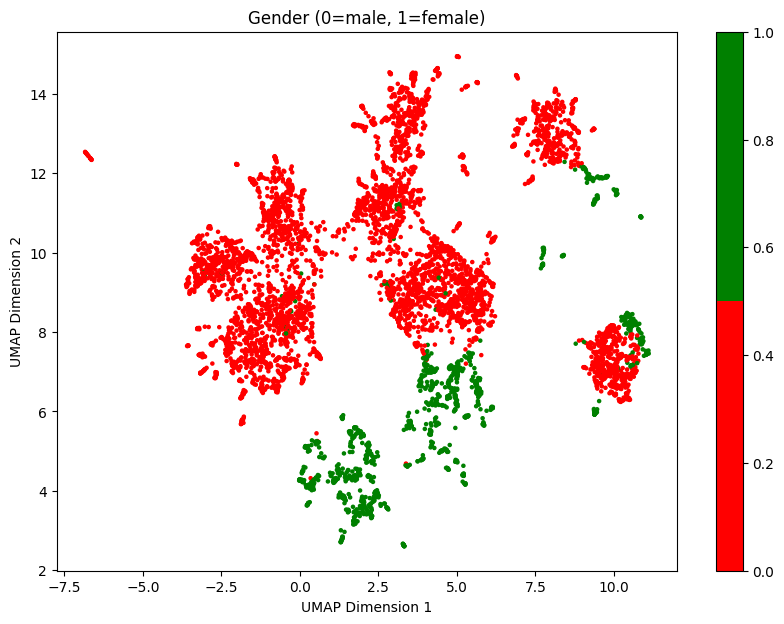

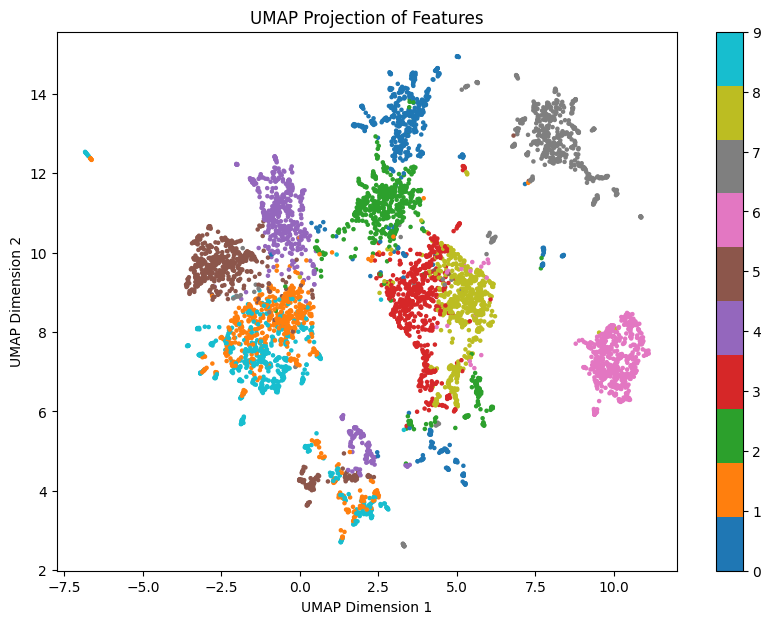

/zhome/e1/b/168603/venv_1/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


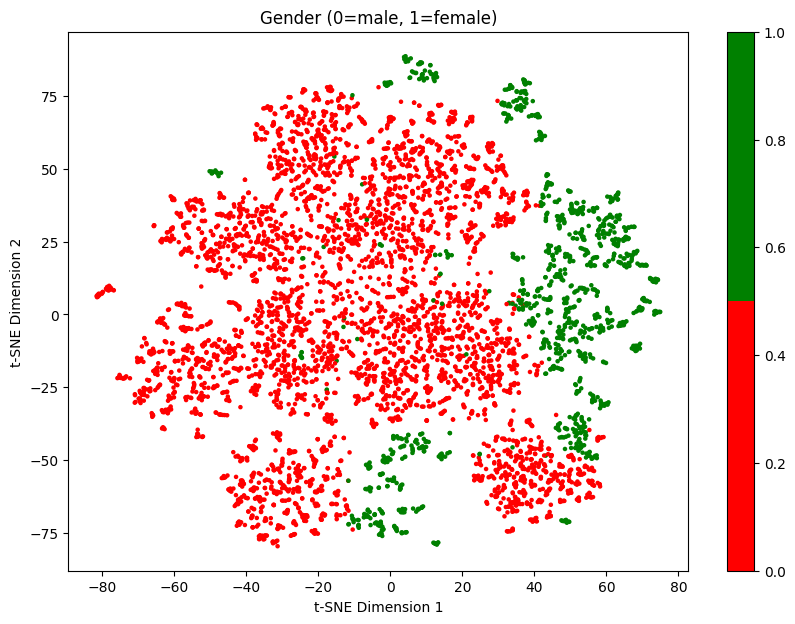

/zhome/e1/b/168603/venv_1/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


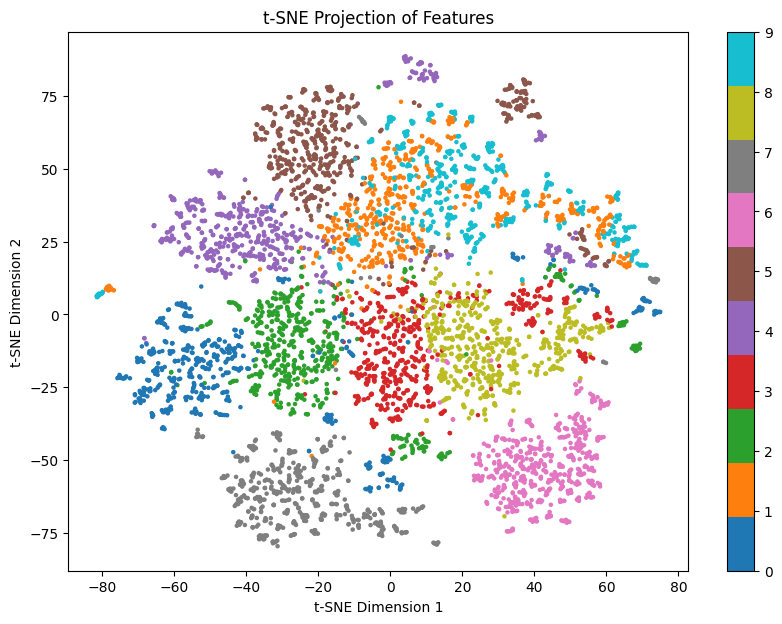

In [44]:
# Plot of feature projection layer both umap and t-sne w gender and digit labels

plot_umap(hook0_n, gender_bin, title = "Gender (0=male, 1=female)")
plot_umap(hook0_n, labels_np)
plot_tsne(hook0_n, gender_bin, title = "Gender (0=male, 1=female)")
plot_tsne(hook0_n, labels_np)

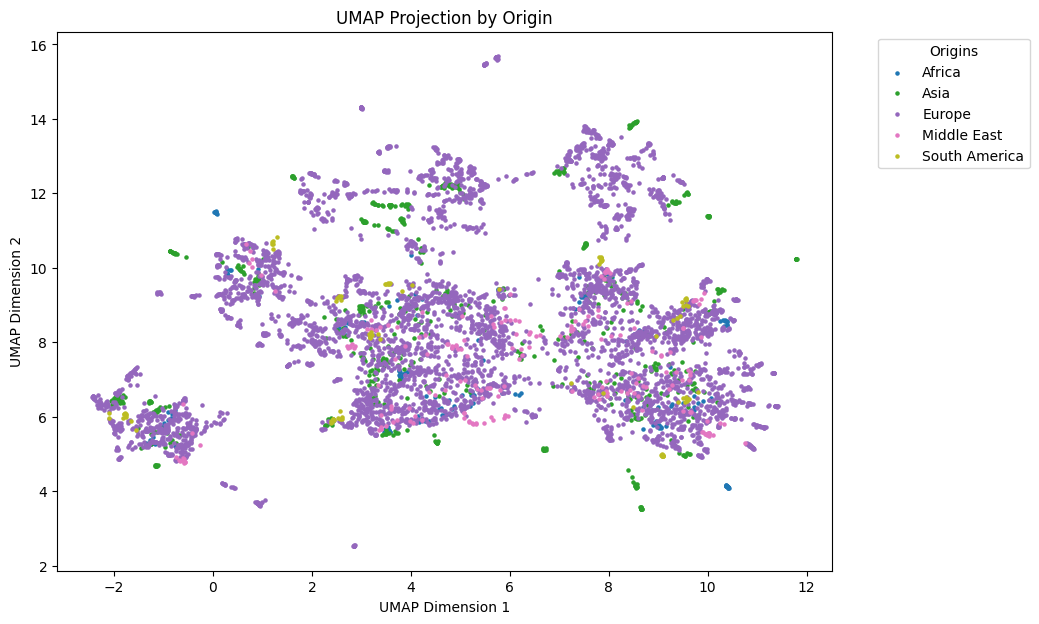

In [21]:
def normalize_origins(origins):
    """
    Normalize detailed origins into broader categories (e.g., continents or countries).
    """
    origin_mapping = {
        "Africa": "Africa",
        "Egypt": "Africa",
        "South Africa": "Africa",
        "Asia": "Asia",
        "China": "Asia",
        "India": "Asia",
        "South Korea": "Asia",
        "Europe": "Europe",
        "Denmark": "Europe",
        "France": "Europe",
        "Spanien": "Europe",
        "Germany": "Europe",
        "Italy": "Europe",
        "Poland": "Europe",
        "Spain": "Europe",
        "Syria": "Middle East",
        "Brazil": "South America"
    }
    # Map each origin to its normalized category
    return np.array([origin_mapping[origin.split(", ")[1]] for origin in origins])
    
def create_origin_color_mapping(unique_origins):
    """
    Assign unique colors to normalized origin categories.
    """
    num_origins = len(unique_origins)
    cmap = colormaps['tab20']  # Use 'tab20' for diverse colors
    colors = [cmap(i / num_origins) for i in range(num_origins)]
    return {origin: colors[i] for i, origin in enumerate(unique_origins)}

def plot_umap_with_origins(features, origins, n_neighbors=15, min_dist=0.1, n_components=2, random_state=42, title="UMAP Projection by Origin"):
    """
    Plot UMAP embeddings colored by normalized origin categories.
    """
    # Normalize origins
    grouped_origins = normalize_origins(origins)

    # Create unique label-color mapping
    unique_origins = np.unique(grouped_origins)
    color_mapping = create_origin_color_mapping(unique_origins)

    # Map grouped origins to colors
    origin_colors = np.array([color_mapping[origin] for origin in grouped_origins])

    # UMAP Projection
    umap_reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components, random_state=random_state)
    umap_embeddings = umap_reducer.fit_transform(features)
    
    # Plot UMAP
    plt.figure(figsize=(10, 7))
    for origin, color in color_mapping.items():
        mask = grouped_origins == origin
        plt.scatter(umap_embeddings[mask, 0], umap_embeddings[mask, 1], c=[color], label=origin, s=5)

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Origins")
    plt.title(title)
    plt.xlabel("UMAP Dimension 1")
    plt.ylabel("UMAP Dimension 2")
    plt.show()
    
plot_umap_with_origins(hook1_n, origins)

In [35]:
# Time to calculate dist matrix
start_time = time.time()
distances = squareform(pdist(hook5_n, metric='euclidean'))
print("--- %s seconds ---" % (time.time() - start_time))

--- 7.59205436706543 seconds ---


# Score graphs

In [ ]:
from sklearn.neighbors import NearestNeighbors

def calculate_class_metric(features, labels):
    """
    Computes a discriminative power (DP) metric for clustering, which evaluates
    the separation between clusters based on their means and within-cluster variances.

    Args:
        features (np.ndarray): Feature matrix of shape (n_samples, n_features).
        labels (np.ndarray): Cluster labels for the samples of shape (n_samples,).

    Returns:
        float: Discriminative power (DP) score.
    """
    n_samples, n_features = features.shape
    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels)
    
    # Initialize storage for cluster-specific statistics
    cluster_means = np.zeros((n_clusters, n_features))
    cluster_sizes = np.zeros(n_clusters)
    within_variances = np.zeros(n_clusters)
    
    # Calculate cluster means and sizes
    for cluster_idx, label in enumerate(unique_labels):
        cluster_data = features[labels == label]
        cluster_means[cluster_idx] = np.mean(cluster_data, axis=0)
        cluster_sizes[cluster_idx] = cluster_data.shape[0]
        
        # Compute within-cluster variance for the cluster
        within_variances[cluster_idx] = np.sum(
            np.sum((cluster_data - cluster_means[cluster_idx]) ** 2, axis=0)
        ) / (cluster_sizes[cluster_idx] - 1)

    total_samples = np.sum(cluster_sizes)
    
    # Calculate pairwise between-cluster and within-cluster variances
    between_variances = []
    pairwise_within_variances = []
    for i in range(n_clusters):
        for j in range(i + 1, n_clusters):  # Avoid duplicate pairs
            between_variance = np.sum((cluster_means[i] - cluster_means[j]) ** 2)
            within_variance_sum = within_variances[i] + within_variances[j]
            between_variances.append(((i, j), between_variance))
            pairwise_within_variances.append(((i, j), within_variance_sum))
    
    # Compute weighted numerator and denominator for DP calculation
    weighted_numerator = 0.0
    weighted_denominator = 0.0
    for i in range(n_clusters - 1):
        for j in range(i + 1, n_clusters):
            weight_ij = (cluster_sizes[i] * cluster_sizes[j]) / total_samples
            dp_ratio = between_variances[i][1] / (pairwise_within_variances[j][1])
            weighted_numerator += weight_ij * dp_ratio
            weighted_denominator += weight_ij
    
    # Final DP score
    dp_score = weighted_numerator / (weighted_denominator + 1e-10)

    return dp_score
    
def nn_metric(data, labels, t=0.8):
    #min_nn = int(len(data) * pct)
    min_nn = 5
    
    nbrs = NearestNeighbors(n_neighbors=min_nn + 1).fit(data)
    _, indices = nbrs.kneighbors(data)

    mm_c = np.array([
        np.sum(labels[neighbors[1:]] != labels[i]) for i, neighbors in enumerate(indices)
    ])

    point_mm = mm_c / min_nn
    score_arr = (point_mm <= t).astype(int)
    metric = np.sum(score_arr) / len(data)
    return metric

--- 0.2261970043182373 seconds ---


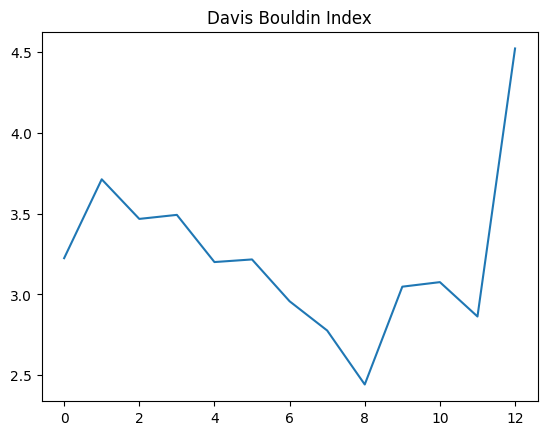

In [168]:
from sklearn.metrics import davies_bouldin_score

s_time = time.time()
scores = []
for h in hookn:
    metric = davies_bouldin_score(h, labels_np)
    scores.append(metric)
print("--- %s seconds ---" % (time.time() - s_time))

plt.plot(scores)
plt.title('Davis Bouldin Index')
plt.show()

--- 17.356305599212646 seconds ---


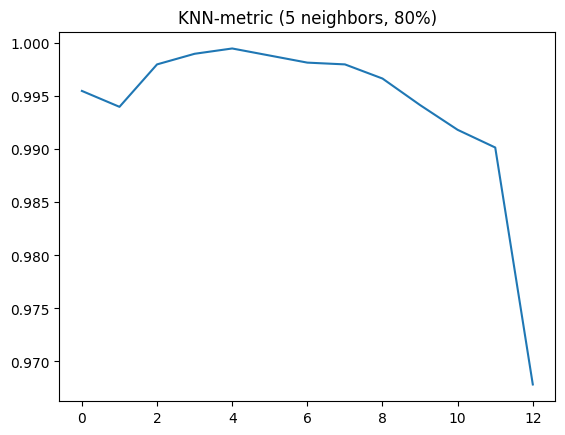

In [171]:
s_time = time.time()
scores = []
for h in hookn:
    metric = nn_metric(h, labels_np, t=0.8)
    scores.append(metric)

print("--- %s seconds ---" % (time.time() - s_time))

plt.plot(scores)
plt.title('KNN-metric (5 neighbors, 80%)')
plt.show()

--- 0.23881268501281738 seconds ---


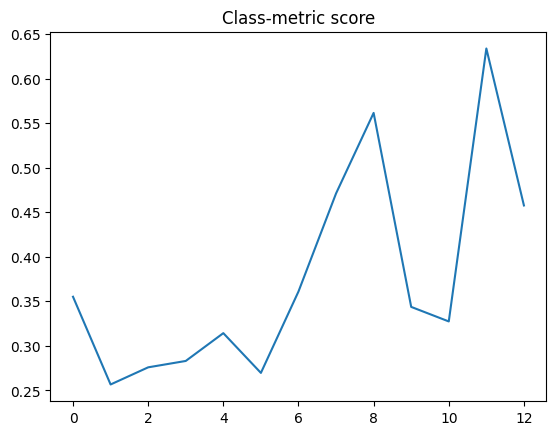

In [164]:
s_time = time.time()
scores = []
for h in hookn:
    temp = class_metric(h, labels_np)
    scores.append(temp)
print("--- %s seconds ---" % (time.time() - s_time))
plt.plot(scores)
plt.title('Class-metric score')
plt.show()

### UMAP of model2 (fine-tuned) (NOT IN USE)

In [ ]:
# Load saved model
model2 = Wav2Vec2ForSequenceClassification.from_pretrained("facebook/wav2vec2-base", num_labels=10)
model2.load_state_dict(torch.load("seq-class-fine.pth", weights_only=True))
model2.to(device)
model2.eval()

In [ ]:
#ph2, pf2 = register_hook(model2.projector)
#fh2, fpf2 = register_hook(model2.wav2vec2.feature_projection)
hook1, hook1_s = register_hook(model2.wav2vec2.encoder.layers[0].attention)
hook2, hook2_s = register_hook(model2.wav2vec2.encoder.layers[1].attention)
hook3, hook3_s = register_hook(model2.wav2vec2.encoder.layers[2].attention)
hook4, hook4_s = register_hook(model2.wav2vec2.encoder.layers[3].attention)
hook5, hook5_s = register_hook(model2.wav2vec2.encoder.layers[4].attention)

all_labels = forward_pass(model2, test_loader)

# Remove the hook after extraction
#ph2.remove()
#fh2.remove()
hook1.remove()
hook2.remove()
hook3.remove()
hook4.remove()
hook5.remove()

# Stack the collected features and labels
hook1_s = torch.cat(hook1_s, dim=0)
hook2_s = torch.cat(hook2_s, dim=0)
hook3_s = torch.cat(hook3_s, dim=0)
hook4_s = torch.cat(hook4_s, dim=0)
hook5_s = torch.cat(hook5_s, dim=0)
all_labels = torch.cat(all_labels, dim=0)

# Convert to NumPy for UMAP
hook1_n = hook1_s.cpu().numpy()
hook2_n = hook2_s.cpu().numpy()
hook3_n = hook3_s.cpu().numpy()
hook4_n = hook4_s.cpu().numpy()
hook5_n = hook5_s.cpu().numpy()
labels_np = all_labels.cpu().numpy()

# UMAP OF ALL LAYERS

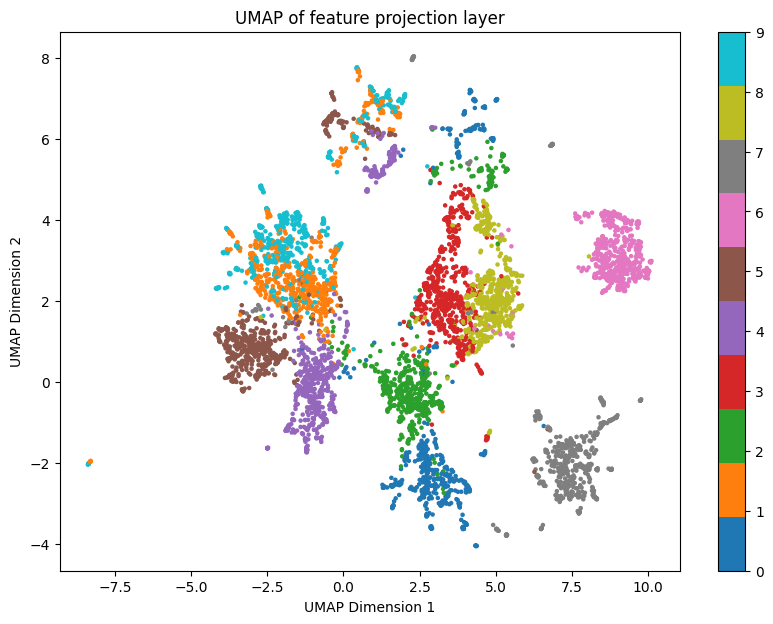

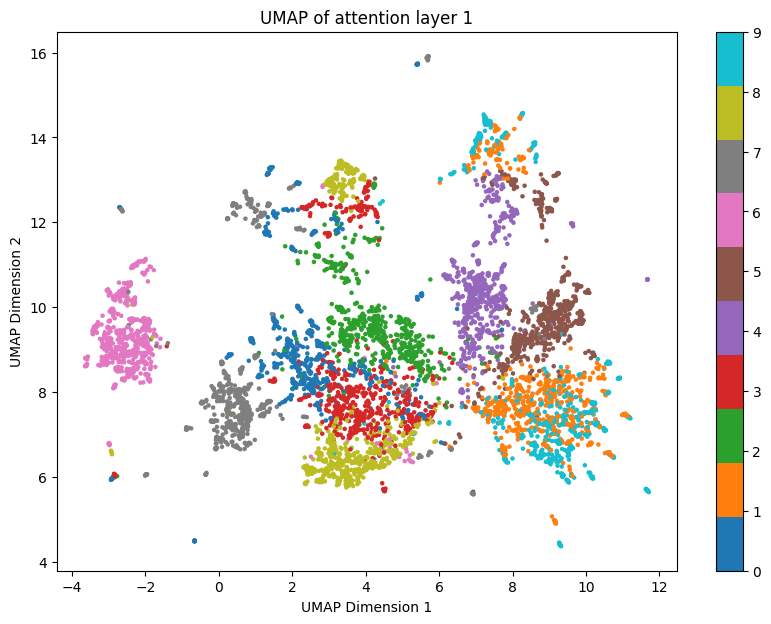

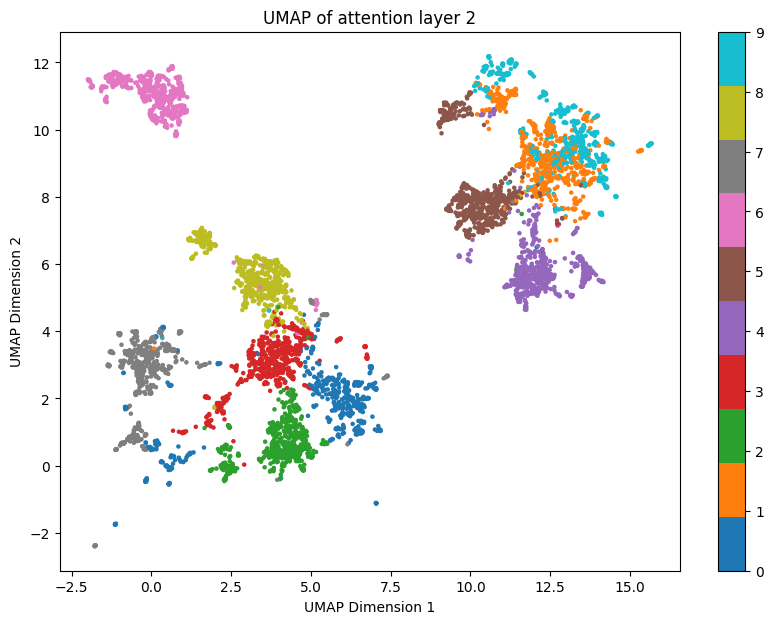

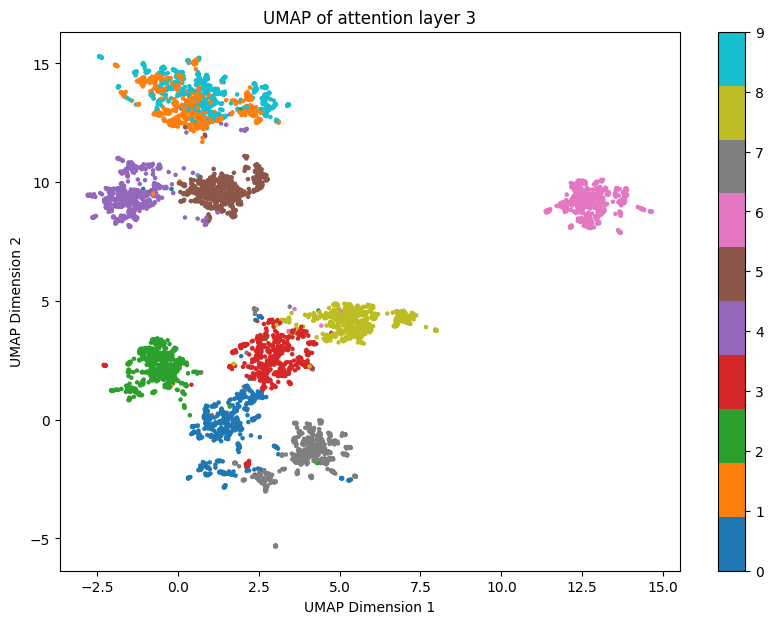

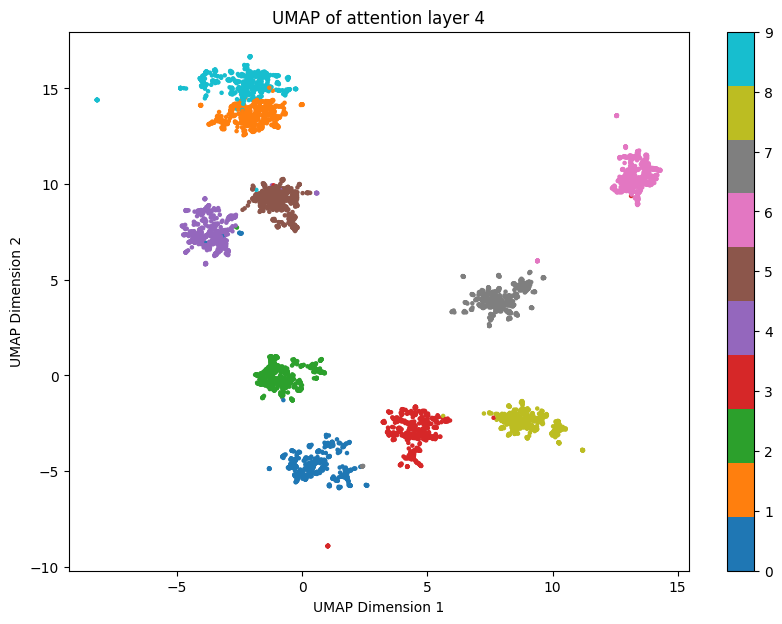

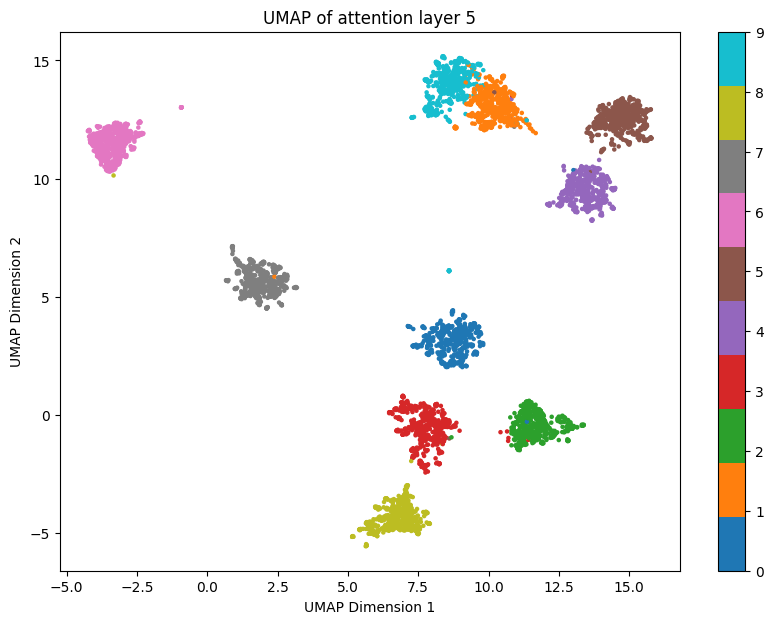

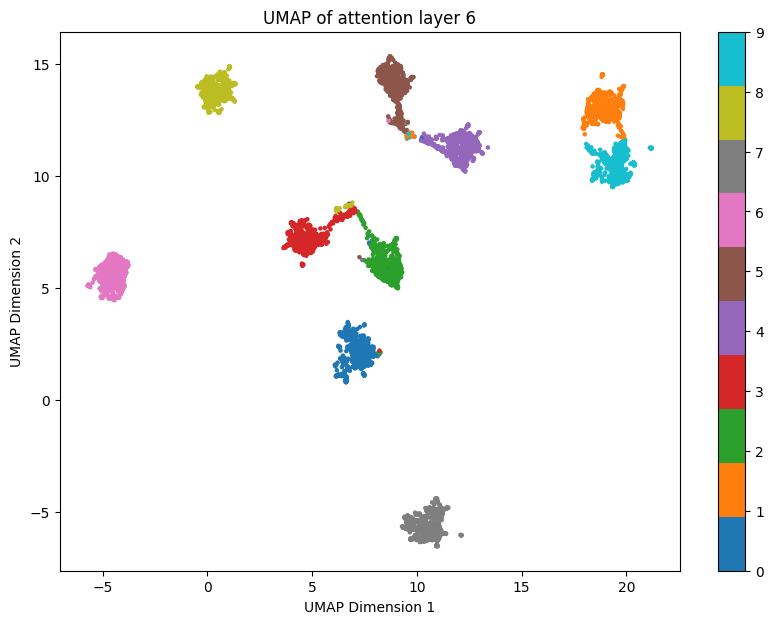

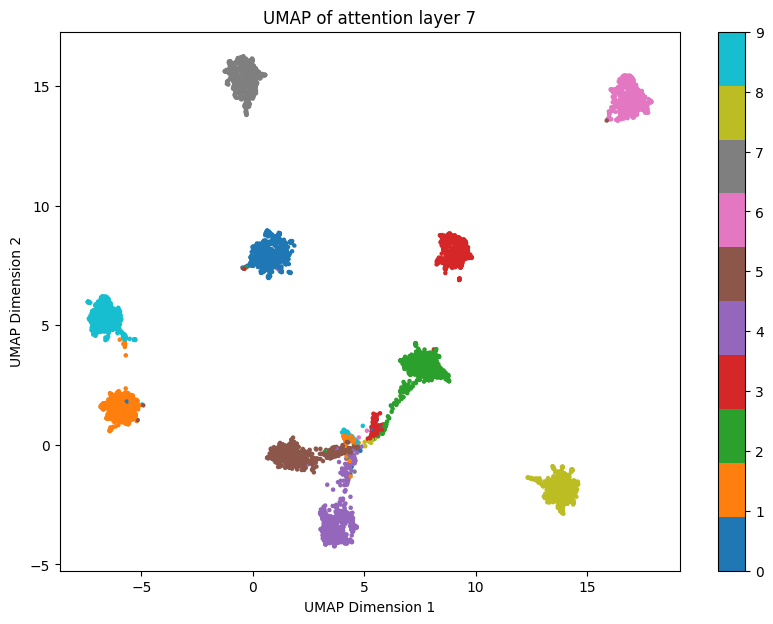

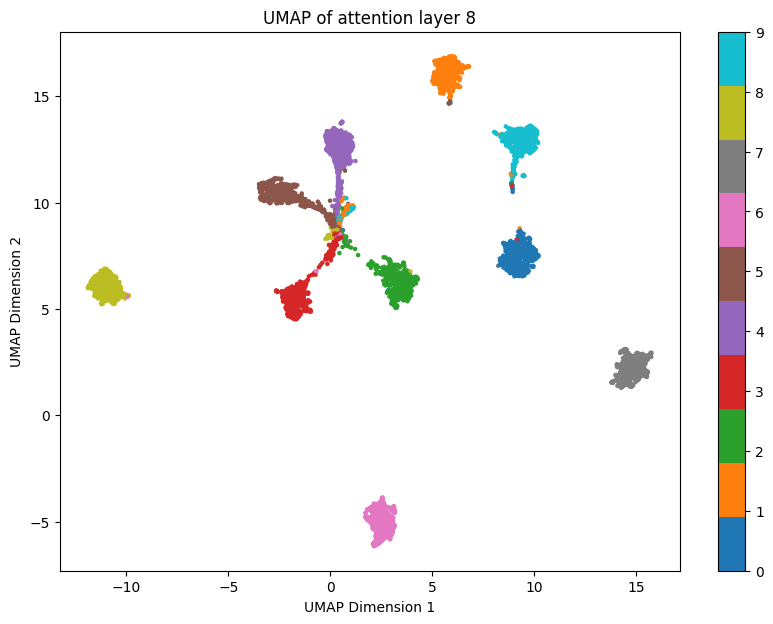

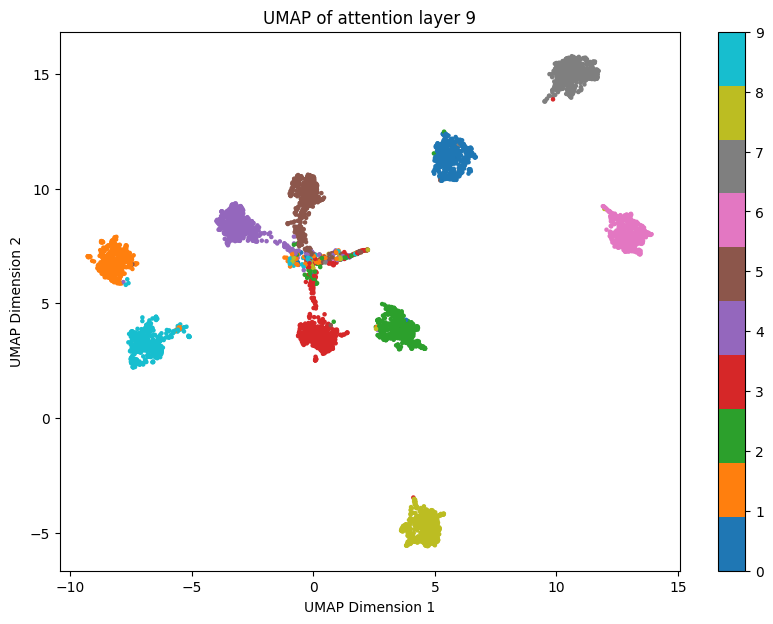

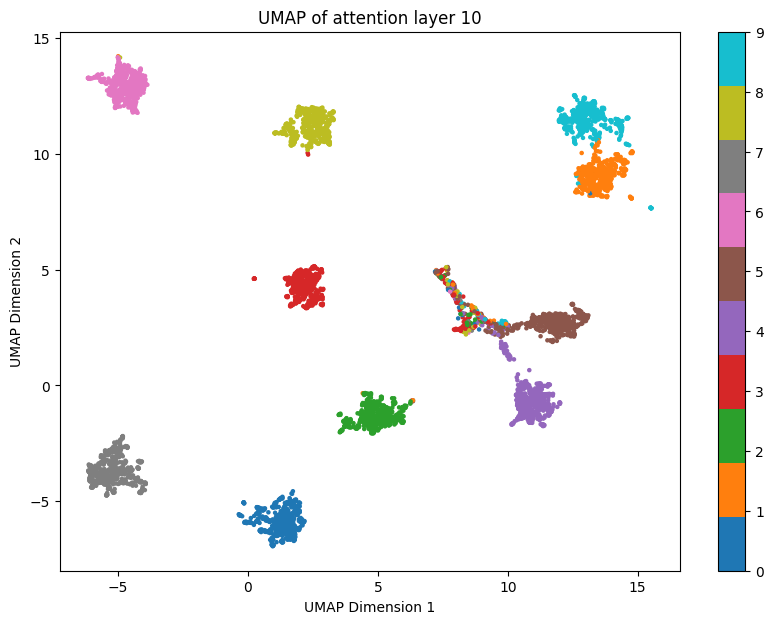

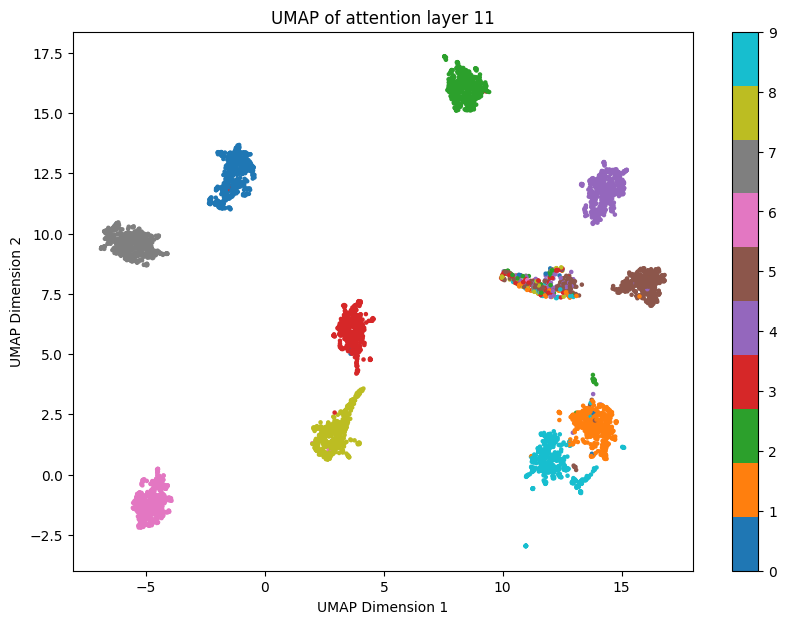

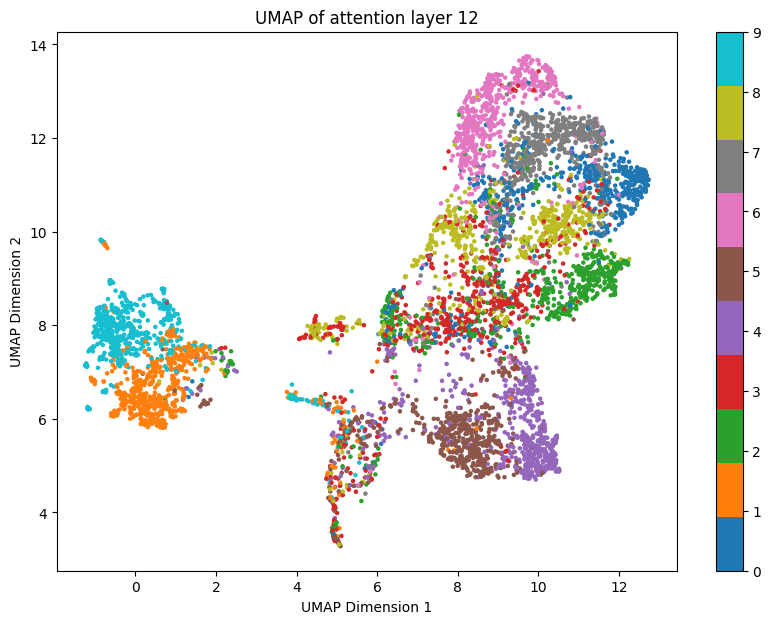

In [74]:
i = 0
for h in hookn:
    if i==0:
        plot_umap(h, labels_np, title=f"UMAP of feature projection layer", random_state=69)
    else:
        plot_umap(h, labels_np, title=f"UMAP of attention layer {i}", random_state=69)
    i+=1

# t-SNE OF ALL LAYERS

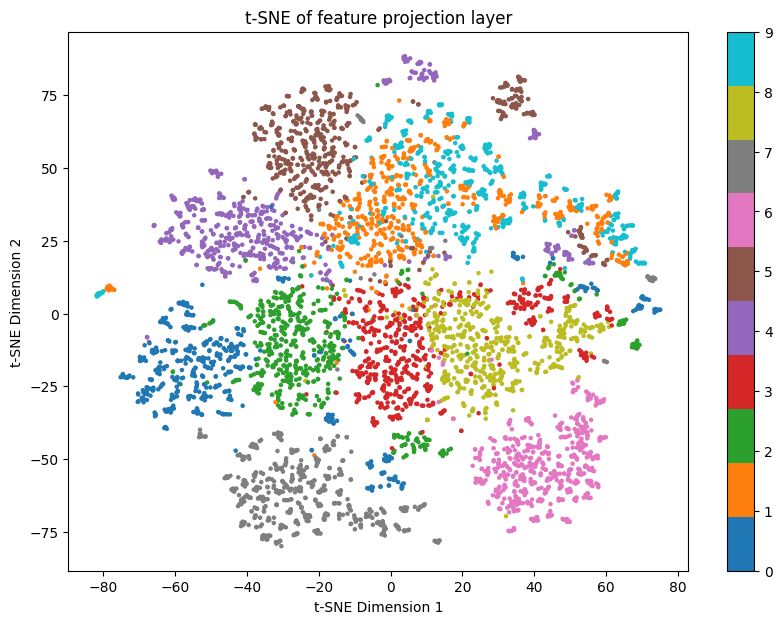

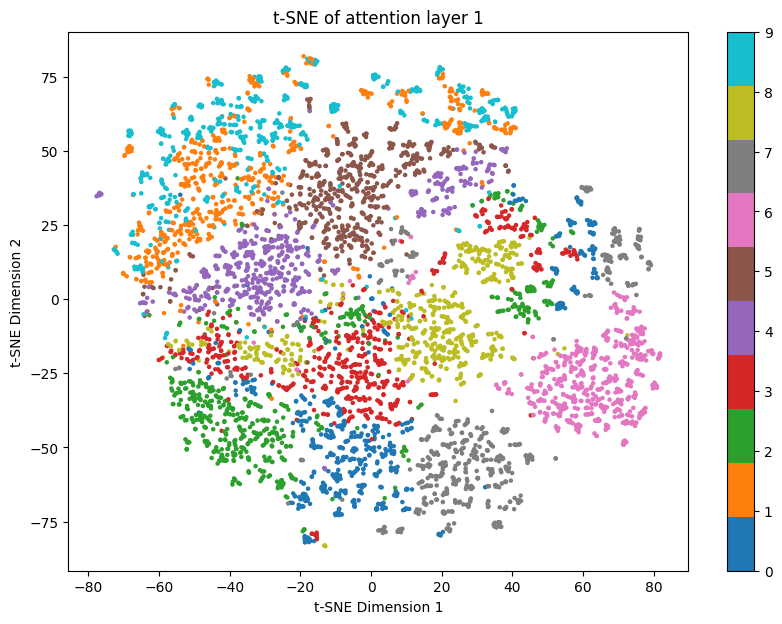

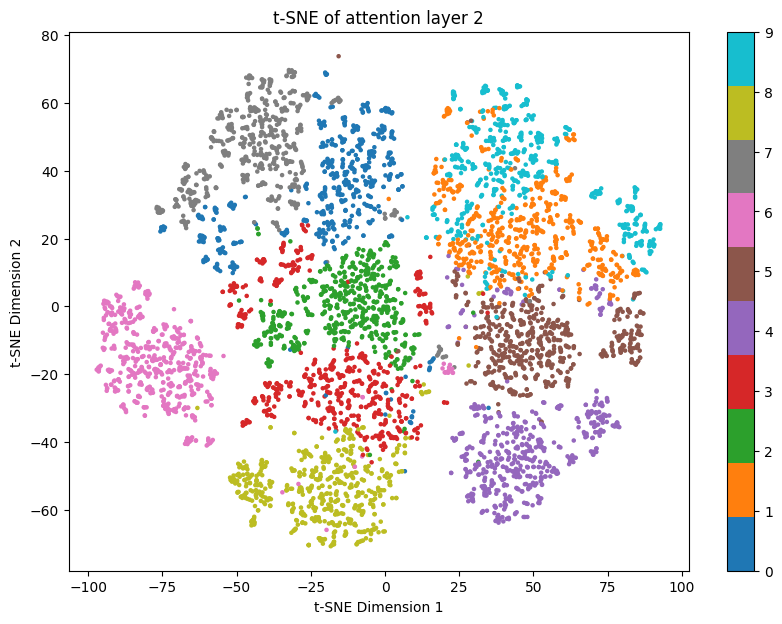

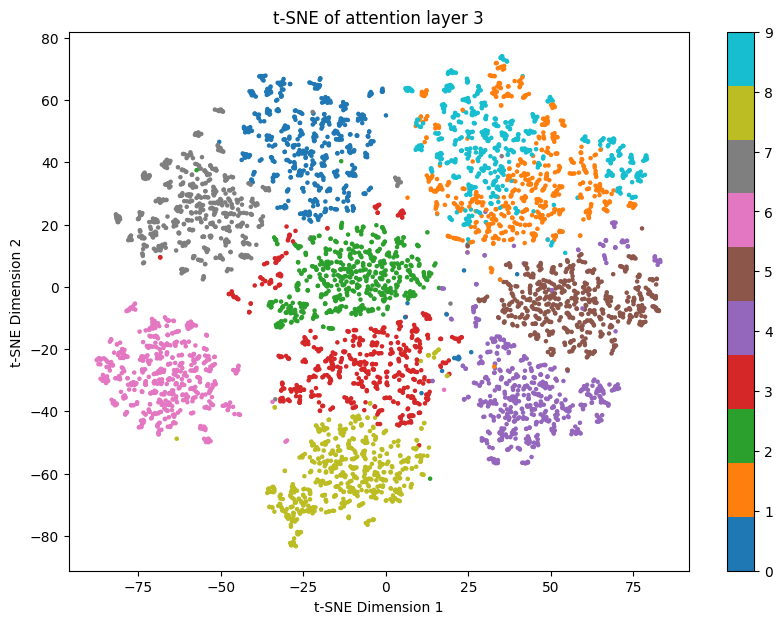

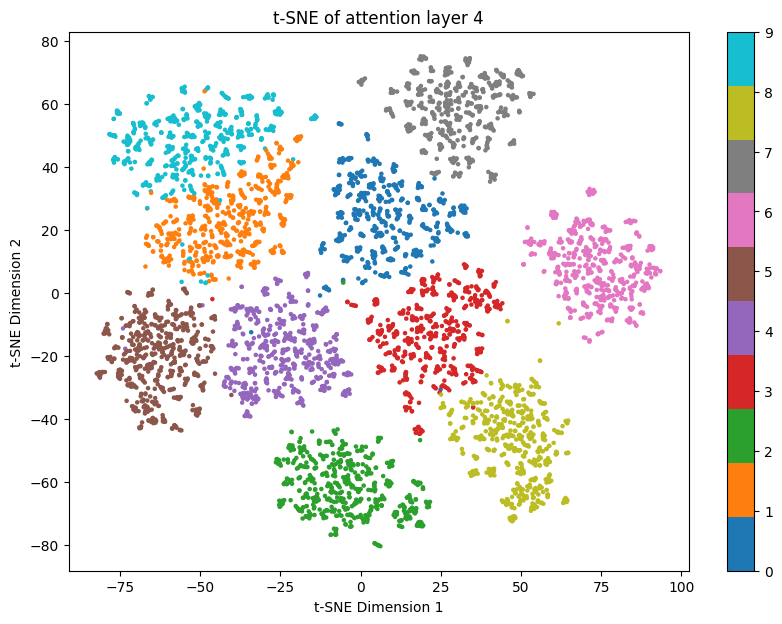

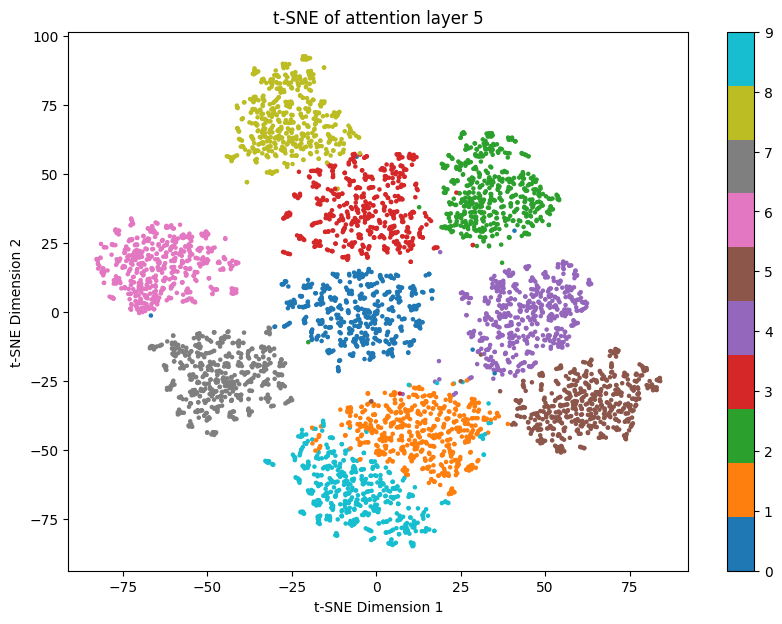

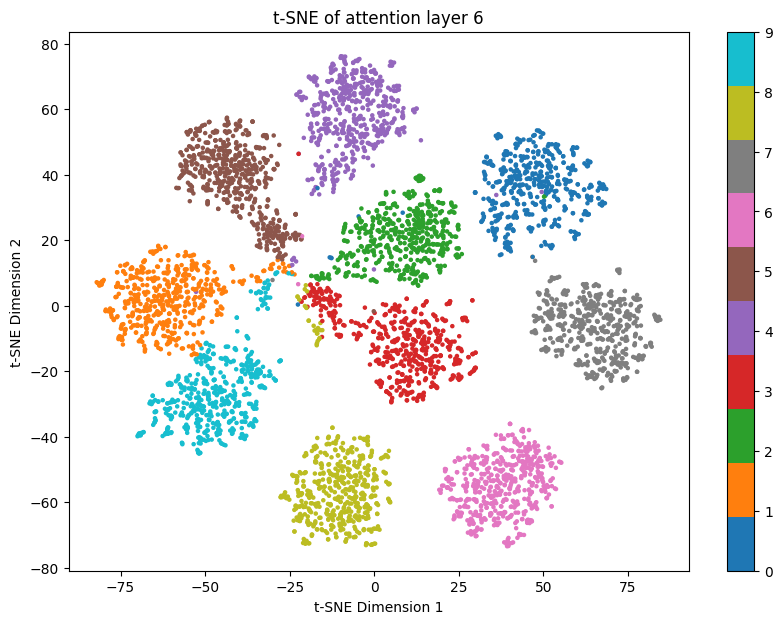

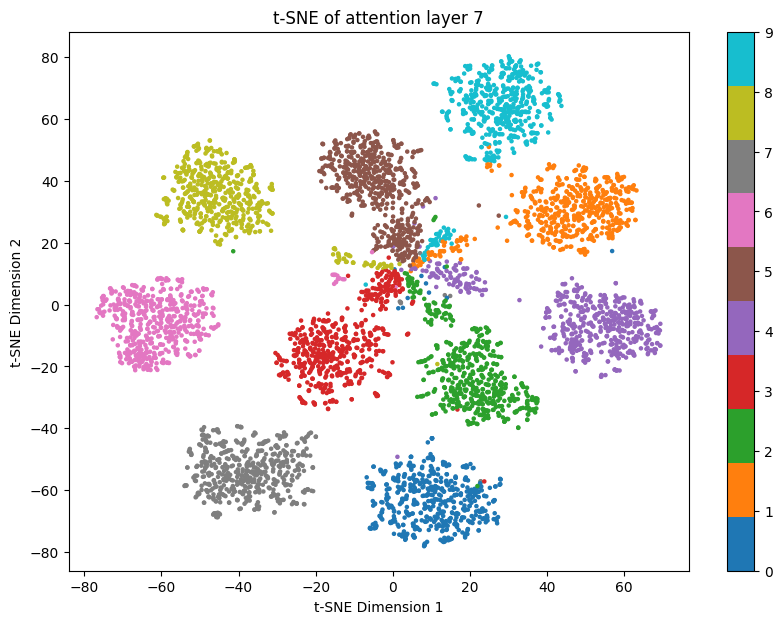

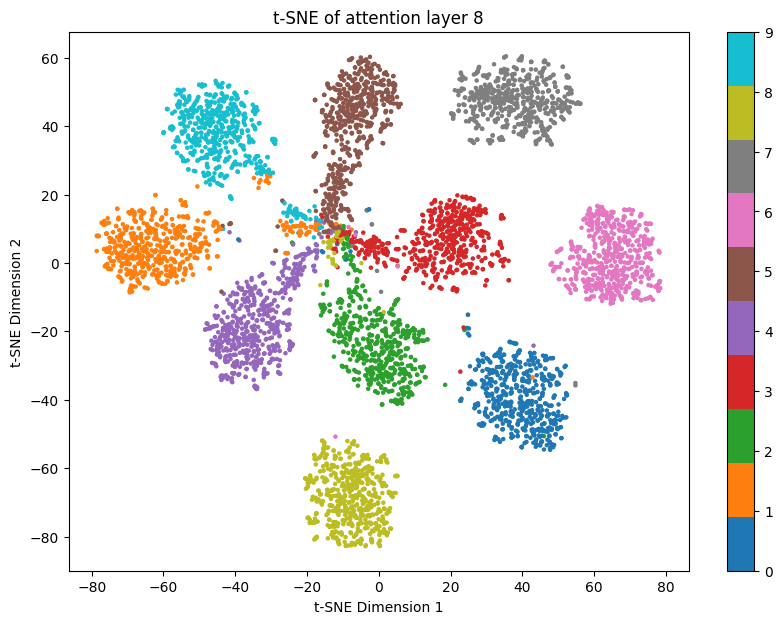

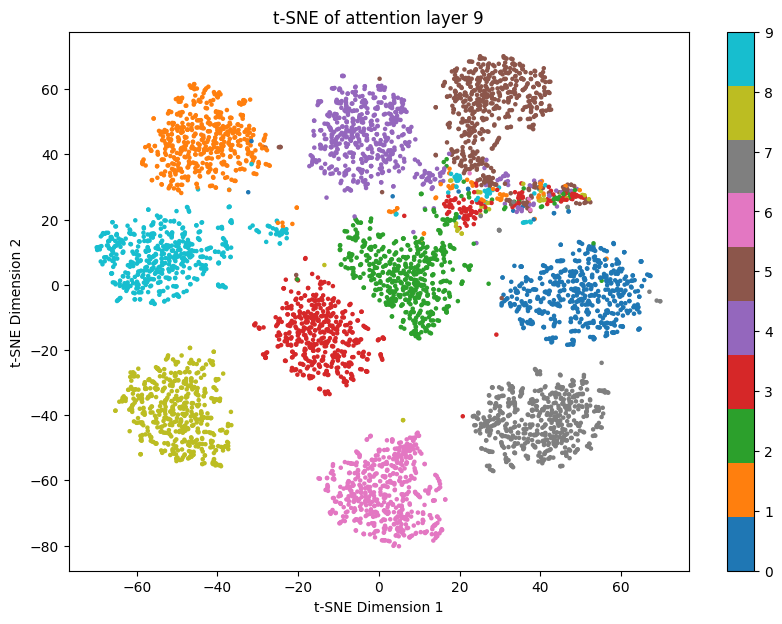

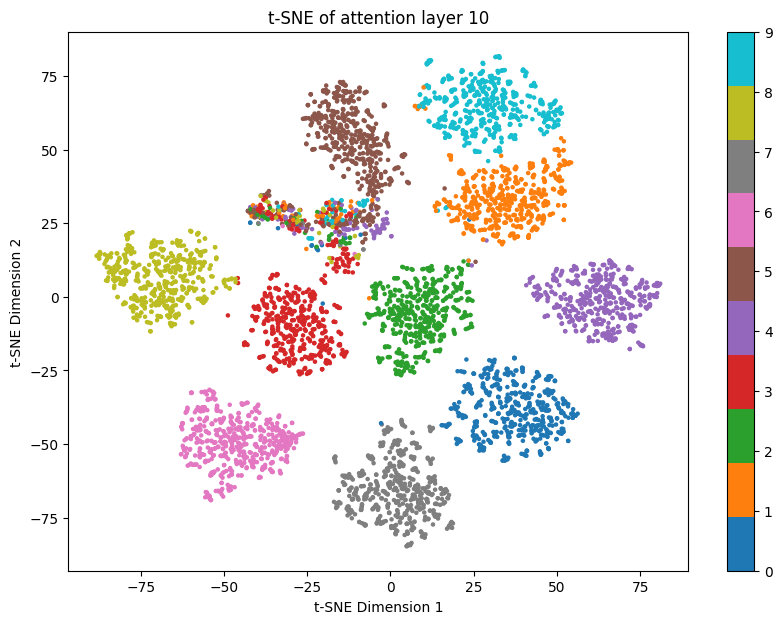

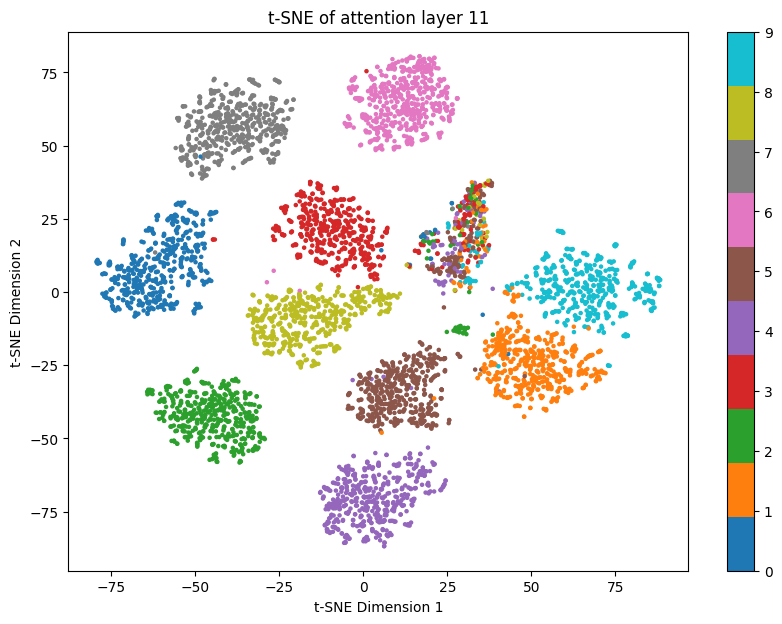

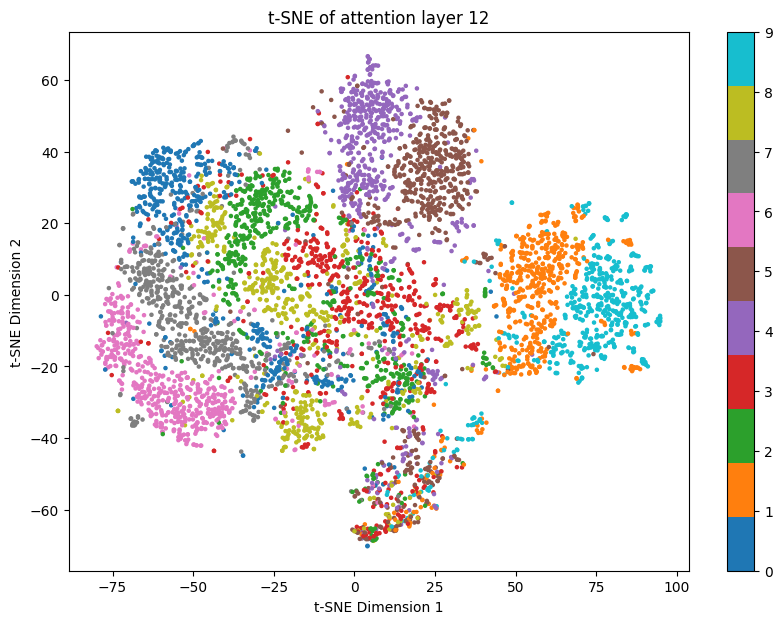

In [76]:
i = 0
for h in hookn:
    if i==0:
        plot_tsne(h, labels_np, title=f"t-SNE of feature projection layer", random_state=69)
    else:
        plot_tsne(h, labels_np, title=f"t-SNE of attention layer {i}", random_state=69)
    i+=1

# Some testing w simulated data

In [160]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score

# Parameters
n_samples = 6000  # Number of samples per cluster
n_clusters = 10  # Number of clusters
n_features = 2  # Number of features
np.random.seed(42)

# Define 5 tests with mixed configurations of separated and overlapping clusters
test_configs = [
    {"separation": 1, "spread": 1},  
    {"separation": 1, "spread": 2},  
    {"separation": 2, "spread": 3},  
    {"separation": 2, "spread": 6}, 
    {"separation": 50, "spread": 2}
]

dbi_scores = []
normalized_dbi_scores = []
ch_scores = []
normalized_ch_scores = []

# Loop through the configurations and compute scores
for i, config in enumerate(test_configs, 1):
    dist, spread = config["separation"], config["spread"]
    
    # Generate blobs with the defined separation and spread
    data, labels = make_blobs(n_samples=n_samples*n_clusters, centers=n_clusters, 
                                         n_features=n_features, cluster_std=spread, 
                                         center_box=(-dist, dist), random_state=42)
    
    # Standardize the data
    scaler = StandardScaler()
    data = scaler.fit_transform(data)  # Scaling the data

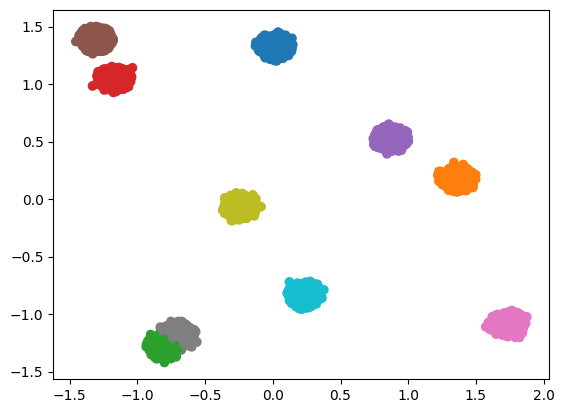

799.946673414098


In [151]:
plt.scatter(data[:,0], data[:,1], c=labels, cmap='tab10')
plt.show()
print(class_metric(data,labels))

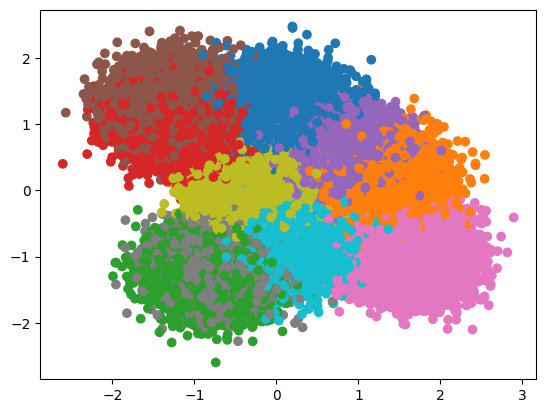

8.06869763424158


In [153]:
plt.scatter(data[:,0], data[:,1], c=labels, cmap='tab10')
plt.show()
print(class_metric(data,labels))

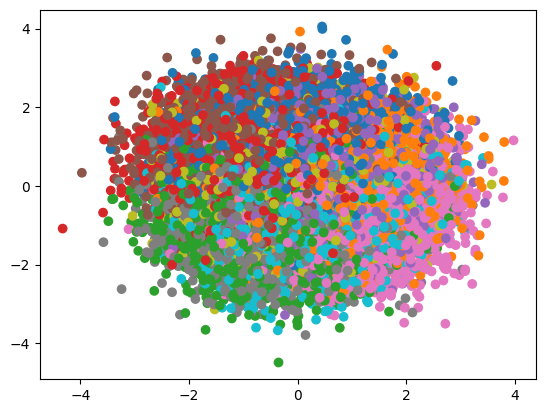

0.3384343628195293


In [155]:
plt.scatter(data[:,0], data[:,1], c=labels, cmap='tab10')
plt.show()
print(class_metric(data,labels))

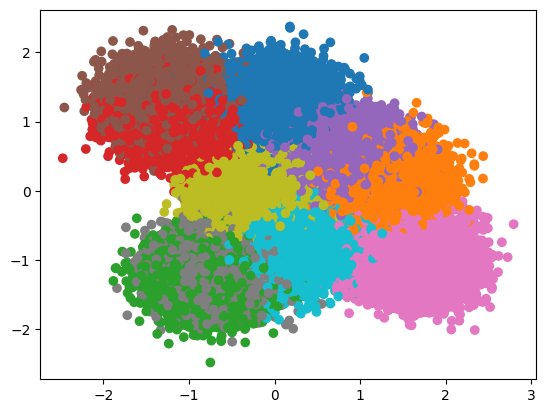

10.105675372412685


In [157]:
plt.scatter(data[:,0], data[:,1], c=labels, cmap='tab10')
plt.show()
print(class_metric(data,labels))

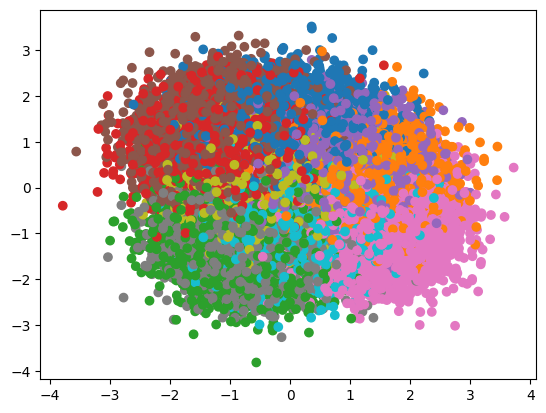

1.3226498736665386


In [159]:
plt.scatter(data[:,0], data[:,1], c=labels, cmap='tab10')
plt.show()
print(class_metric(data,labels))

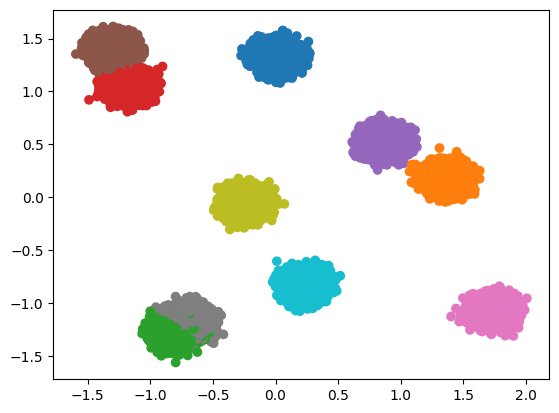

200.0563366272528


In [161]:
plt.scatter(data[:,0], data[:,1], c=labels, cmap='tab10')
plt.show()
print(class_metric(data,labels))